In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

df = pd.read_csv('data_cleaned.csv')
df_orders = pd.read_csv('orders_aggregated.csv')

date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 
             'order_estimated_delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
    if col in df_orders.columns:
        df_orders[col] = pd.to_datetime(df_orders[col])

df['order_month'] = pd.to_datetime(df['order_month'].astype(str))
df_orders['order_month'] = pd.to_datetime(df_orders['order_month'].astype(str))

print(f"Dataset carregado: {len(df):,} itens, {len(df_orders):,} pedidos")
print()

Dataset carregado: 112,640 itens, 98,658 pedidos



KPIs PRINCIPAIS

In [5]:
# 1.1. Receita e Componentes

total_revenue = df_orders['total'].sum()
total_subtotal = df_orders['subtotal'].sum()
total_freight = df_orders['freight'].sum()

print(f"Receita Total: R$ {total_revenue:,.2f}")
print(f"  └─ Subtotal (Produtos): R$ {total_subtotal:,.2f} ({total_subtotal/total_revenue*100:.2f}%)")
print(f"  └─ Frete: R$ {total_freight:,.2f} ({total_freight/total_revenue*100:.2f}%)")
print()

Receita Total: R$ 15,841,171.67
  └─ Subtotal (Produtos): R$ 13,589,426.41 (85.79%)
  └─ Frete: R$ 2,251,745.26 (14.21%)



In [7]:
#TICKET MÉDIO
avg_ticket = df_orders['total'].mean()
median_ticket = df_orders['total'].median()

print(f"Ticket Médio: R$ {avg_ticket:.2f}")
print(f"Ticket Mediano: R$ {median_ticket:.2f}")
print()

Ticket Médio: R$ 160.57
Ticket Mediano: R$ 105.29



In [8]:
avg_freight = df_orders['freight'].mean()
freight_share = (total_freight / total_revenue) * 100

print(f"Frete Médio: R$ {avg_freight:.2f}")
print(f"Take-rate de Frete: {freight_share:.2f}%")
print(f"  (Proporção do frete na receita total)")
print()


Frete Médio: R$ 22.82
Take-rate de Frete: 14.21%
  (Proporção do frete na receita total)



In [9]:
# Calcular desconto implícito (diferença entre payment_value e total)
df_orders['discount_amount'] = df_orders['payment_value'] - df_orders['total']
df_orders['discount_pct'] = (df_orders['discount_amount'] / df_orders['total'] * 100).clip(-100, 100)

avg_discount_pct = df_orders['discount_pct'].mean()
median_discount_pct = df_orders['discount_pct'].median()

print(f"Desconto Médio: {avg_discount_pct:.2f}%")
print(f"Desconto Mediano: {median_discount_pct:.2f}%")
print(f"⚠ Nota: Valores negativos indicam pagamento > total (possível taxa de serviço)")
print()

Desconto Médio: 0.02%
Desconto Mediano: 0.00%
⚠ Nota: Valores negativos indicam pagamento > total (possível taxa de serviço)



In [11]:
# 1.5. Prazo de Entrega
avg_delivery_time = df_orders['delivery_lead_time'].mean()
median_delivery_time = df_orders['delivery_lead_time'].median()

print(f"Prazo Médio de Entrega: {avg_delivery_time:.2f} dias")
print(f"Prazo Mediano de Entrega: {median_delivery_time:.2f} dias")
print()

Prazo Médio de Entrega: 12.09 dias
Prazo Mediano de Entrega: 10.00 dias



In [13]:
delivered = df_orders[df_orders['order_status'] == 'delivered']
late_orders = delivered[delivered['is_late'] == 1]

late_rate = (len(late_orders) / len(delivered)) * 100
avg_delay = late_orders['delivery_delay_days'].mean()

print(f"Taxa de Atraso: {late_rate:.2f}%")
print(f"Atraso Médio (quando atrasado): {avg_delay:.2f} dias")
print()

Taxa de Atraso: 6.77%
Atraso Médio (quando atrasado): 10.62 dias



In [15]:
# 1.7. Conversão de Pagamento

status_counts = df_orders['order_status'].value_counts()
total_orders = len(df_orders)

confirmed_rate = (status_counts.get('delivered', 0) / total_orders) * 100
canceled_rate = (status_counts.get('canceled', 0) / total_orders) * 100

print(f"Taxa de Confirmação (Delivered): {confirmed_rate:.2f}%")
print(f"Taxa de Cancelamento: {canceled_rate:.2f}%")
print()


# Conversão por tipo de pagamento
print("Conversão por Tipo de Pagamento:")
payment_conversion = df_orders.groupby('payment_type').agg({
    'order_id': 'count',
    'is_confirmed': 'sum',
    'is_canceled': 'sum'
}).reset_index()
payment_conversion['confirmed_rate'] = (payment_conversion['is_confirmed'] / 
                                         payment_conversion['order_id'] * 100)
payment_conversion['canceled_rate'] = (payment_conversion['is_canceled'] / 
                                        payment_conversion['order_id'] * 100)

print(payment_conversion[['payment_type', 'order_id', 'confirmed_rate', 'canceled_rate']].to_string(index=False))
print()


Taxa de Confirmação (Delivered): 97.79%
Taxa de Cancelamento: 0.47%

Conversão por Tipo de Pagamento:
payment_type  order_id  confirmed_rate  canceled_rate
      boleto     19614       97.843377       0.402774
 credit_card     75615       97.786154       0.487998
  debit_card      1520       97.631579       0.394737
     voucher      1908       97.536688       0.366876



ANÁLISE DE SAZONALIDADE

In [16]:
# 2.1. Sazonalidade Mensal

monthly_kpis = df_orders.groupby('order_month').agg({
    'order_id': 'count',
    'total': 'sum',
    'freight': 'mean',
    'delivery_lead_time': 'mean'
}).reset_index()
monthly_kpis.columns = ['month', 'n_orders', 'revenue', 'avg_freight', 'avg_delivery_time']

max_month = monthly_kpis.loc[monthly_kpis['n_orders'].idxmax()]
min_month = monthly_kpis.loc[monthly_kpis['n_orders'].idxmin()]

print(f"Mês com MAIOR volume: {max_month['month'].strftime('%Y-%m')}")
print(f"  └─ {max_month['n_orders']:.0f} pedidos, R$ {max_month['revenue']:,.2f}")
print()
print(f"Mês com MENOR volume: {min_month['month'].strftime('%Y-%m')}")
print(f"  └─ {min_month['n_orders']:.0f} pedidos, R$ {min_month['revenue']:,.2f}")
print()

# 2.2. Sazonalidade por Estado
print("2.2. TOP 5 ESTADOS POR RECEITA")

state_kpis = df_orders.groupby('customer_state').agg({
    'order_id': 'count',
    'total': 'sum'
}).reset_index()
state_kpis.columns = ['state', 'n_orders', 'revenue']
state_kpis = state_kpis.sort_values('revenue', ascending=False).head(5)

print(state_kpis.to_string(index=False))
print()

# 2.3. Sazonalidade por Região
print("2.3. ANÁLISE POR REGIÃO")

region_kpis = df_orders.groupby('customer_region').agg({
    'order_id': 'count',
    'total': ['sum', 'mean'],
    'freight': 'mean',
    'delivery_lead_time': 'mean',
    'is_late': 'mean'
}).reset_index()
region_kpis.columns = ['region', 'n_orders', 'revenue', 'avg_ticket', 
                        'avg_freight', 'avg_delivery_time', 'late_rate']
region_kpis['late_rate'] = region_kpis['late_rate'] * 100
region_kpis = region_kpis.sort_values('revenue', ascending=False)

print(region_kpis.to_string(index=False))
print()

Mês com MAIOR volume: 2017-11
  └─ 7451 pedidos, R$ 1,179,143.77

Mês com MENOR volume: 2016-12
  └─ 1 pedidos, R$ 19.62

2.2. TOP 5 ESTADOS POR RECEITA
state  n_orders    revenue
   SP     41371 5920134.69
   RJ     12761 2129368.40
   MG     11542 1855907.68
   RS      5431  885556.01
   PR      4998  800935.44

2.3. ANÁLISE POR REGIÃO
      region  n_orders     revenue  avg_ticket  avg_freight  avg_delivery_time  late_rate
     Sudeste     67699 10230212.68  151.113202    19.864208          10.289269   5.980886
         Sul     14041  2296705.05  163.571330    24.429444          13.558636   5.804430
    Nordeste      9336  1880799.54  201.456677    35.915359          19.536046  12.317909
Centro-Oeste      5744  1023062.00  178.109680    26.566842          14.563656   6.389276
       Norte      1838   410392.40  223.282046    41.370343          22.144209   8.378672



PERFORMANCE LOGÍSTICA

In [ ]:
# Análise por região com foco em logística

logistics_by_region = df_orders[df_orders['order_status'] == 'delivered'].groupby('customer_region').agg({
    'delivery_lead_time': ['mean', 'median', 'std'],
    'is_late': 'mean',
    'delivery_delay_days': lambda x: x[x > 0].mean() if (x > 0).any() else 0
}).reset_index()

logistics_by_region.columns = ['region', 'avg_lead_time', 'median_lead_time', 
                                 'std_lead_time', 'late_rate', 'avg_delay_when_late']
logistics_by_region['late_rate'] = logistics_by_region['late_rate'] * 100
logistics_by_region = logistics_by_region.sort_values('late_rate', ascending=False)

print(logistics_by_region.to_string(index=False))
print()

print("INSIGHTS LOGÍSTICOS:")
worst_region = logistics_by_region.iloc[0]
print(f"  • Região com PIOR performance: {worst_region['region']}")
print(f"    - Taxa de atraso: {worst_region['late_rate']:.2f}%")
print(f"    - Prazo médio: {worst_region['avg_lead_time']:.2f} dias")
print()

best_region = logistics_by_region.iloc[-1]
print(f"  • Região com MELHOR performance: {best_region['region']}")
print(f"    - Taxa de atraso: {best_region['late_rate']:.2f}%")
print(f"    - Prazo médio: {best_region['avg_lead_time']:.2f} dias")
print()

      region  avg_lead_time  median_lead_time  std_lead_time  late_rate  avg_delay_when_late
    Nordeste      19.536046              17.0      12.254414  12.715613            12.426087
       Norte      22.144209              20.0      13.100504   8.574610            13.493506
Centro-Oeste      14.563656              13.0       8.393141   6.525605             9.430518
     Sudeste      10.288701               8.0       8.509714   6.114804            10.415020
         Sul      13.557446              12.0       8.437792   5.899812             9.083436

INSIGHTS LOGÍSTICOS:
  • Região com PIOR performance: Nordeste
    - Taxa de atraso: 12.72%
    - Prazo médio: 19.54 dias

  • Região com MELHOR performance: Sul
    - Taxa de atraso: 5.90%
    - Prazo médio: 13.56 dias



MIX DE PRODUTOS

In [19]:
print("4.1. TOP 10 CATEGORIAS POR RECEITA")
print("-"*80)

category_kpis = df.groupby('product_category_name_english').agg({
    'order_id': 'count',
    'total': 'sum',
    'price': 'mean'
}).reset_index()
category_kpis.columns = ['category', 'n_items', 'revenue', 'avg_price']
category_kpis = category_kpis.sort_values('revenue', ascending=False).head(10)

print(category_kpis.to_string(index=False))
print()

4.1. TOP 10 CATEGORIAS POR RECEITA
--------------------------------------------------------------------------------
             category  n_items    revenue  avg_price
        health_beauty     9670 1441248.07 130.163531
        watches_gifts     5991 1305541.61 201.135984
       bed_bath_table    11115 1241681.72  93.296327
       sports_leisure     8641 1156656.48 114.344285
computers_accessories     7825 1059210.78 116.538610
      furniture_decor     8334  902511.79  87.564494
           housewares     6963  778218.31  90.776786
           cool_stuff     3795  719239.72 167.384967
                 auto     4234  685338.36 139.982312
         garden_tools     4347  584219.21 111.630196



INSIGHTS ACIONÁVEIS

In [ ]:
insights = []

# Insight 1: Ticket Médio por Forma de Pagamento
credit_ticket = df_orders[df_orders['payment_type'] == 'credit_card']['total'].mean()
boleto_ticket = df_orders[df_orders['payment_type'] == 'boleto']['total'].mean()
diff_pct = ((credit_ticket - boleto_ticket) / boleto_ticket) * 100

insights.append({
    'id': 1,
    'categoria': 'Receita',
    'insight': f'Clientes que pagam com cartão de crédito têm ticket médio {diff_pct:.1f}% maior (R$ {credit_ticket:.2f}) que boleto (R$ {boleto_ticket:.2f})',
    'acao': 'Incentivar pagamento com cartão através de cashback ou parcelamento sem juros'
})

# Insight 2: Taxa de Atraso Regional
norte_late = logistics_by_region[logistics_by_region['region'] == 'Norte']['late_rate'].values[0]
sudeste_late = logistics_by_region[logistics_by_region['region'] == 'Sudeste']['late_rate'].values[0]

insights.append({
    'id': 2,
    'categoria': 'Logística',
    'insight': f'Região Norte tem taxa de atraso {norte_late:.1f}% vs {sudeste_late:.1f}% no Sudeste - diferença de {norte_late-sudeste_late:.1f} pontos percentuais',
    'acao': 'Revisar parceiros logísticos no Norte e ajustar prazos estimados para reduzir insatisfação'
})

# Insight 3: Frete como % da Receita
insights.append({
    'id': 3,
    'categoria': 'Frete',
    'insight': f'Frete representa {freight_share:.2f}% da receita total - valor significativo que impacta margem',
    'acao': 'Negociar melhores tarifas com transportadoras e considerar frete grátis acima de valor mínimo'
})

# Insight 4: Sazonalidade
growth = ((monthly_kpis['n_orders'].iloc[-3:].mean() - 
           monthly_kpis['n_orders'].iloc[:3].mean()) / 
          monthly_kpis['n_orders'].iloc[:3].mean() * 100)

insights.append({
    'id': 4,
    'categoria': 'Sazonalidade',
    'insight': f'Crescimento de {growth:.1f}% no volume de pedidos comparando início e fim do período',
    'acao': 'Preparar estoque e capacidade logística para períodos de pico (Black Friday, Natal)'
})

# Insight 5: Taxa de Cancelamento
insights.append({
    'id': 5,
    'categoria': 'Conversão',
    'insight': f'Taxa de cancelamento de {canceled_rate:.2f}% é baixa, mas representa {status_counts.get("canceled", 0)} pedidos perdidos',
    'acao': 'Investigar motivos de cancelamento e implementar recuperação de carrinho abandonado'
})

# Imprimir insights
for insight in insights:
    print(f"INSIGHT #{insight['id']}: {insight['categoria'].upper()}")
    print(f"  📊 {insight['insight']}")
    print(f"  🎯 Ação: {insight['acao']}")
    print()

5. INSIGHTS ACIONÁVEIS

INSIGHT #1: RECEITA
  📊 Clientes que pagam com cartão de crédito têm ticket médio 14.7% maior (R$ 166.20) que boleto (R$ 144.91)
  🎯 Ação: Incentivar pagamento com cartão através de cashback ou parcelamento sem juros

INSIGHT #2: LOGÍSTICA
  📊 Região Norte tem taxa de atraso 8.6% vs 6.1% no Sudeste - diferença de 2.5 pontos percentuais
  🎯 Ação: Revisar parceiros logísticos no Norte e ajustar prazos estimados para reduzir insatisfação

INSIGHT #3: FRETE
  📊 Frete representa 14.21% da receita total - valor significativo que impacta margem
  🎯 Ação: Negociar melhores tarifas com transportadoras e considerar frete grátis acima de valor mínimo

INSIGHT #4: SAZONALIDADE
  📊 Crescimento de 4058.8% no volume de pedidos comparando início e fim do período
  🎯 Ação: Preparar estoque e capacidade logística para períodos de pico (Black Friday, Natal)

INSIGHT #5: CONVERSÃO
  📊 Taxa de cancelamento de 0.47% é baixa, mas representa 461 pedidos perdidos
  🎯 Ação: Investigar mo

6. GERANDO DASHBOARD DE KPIs
--------------------------------------------------------------------------------


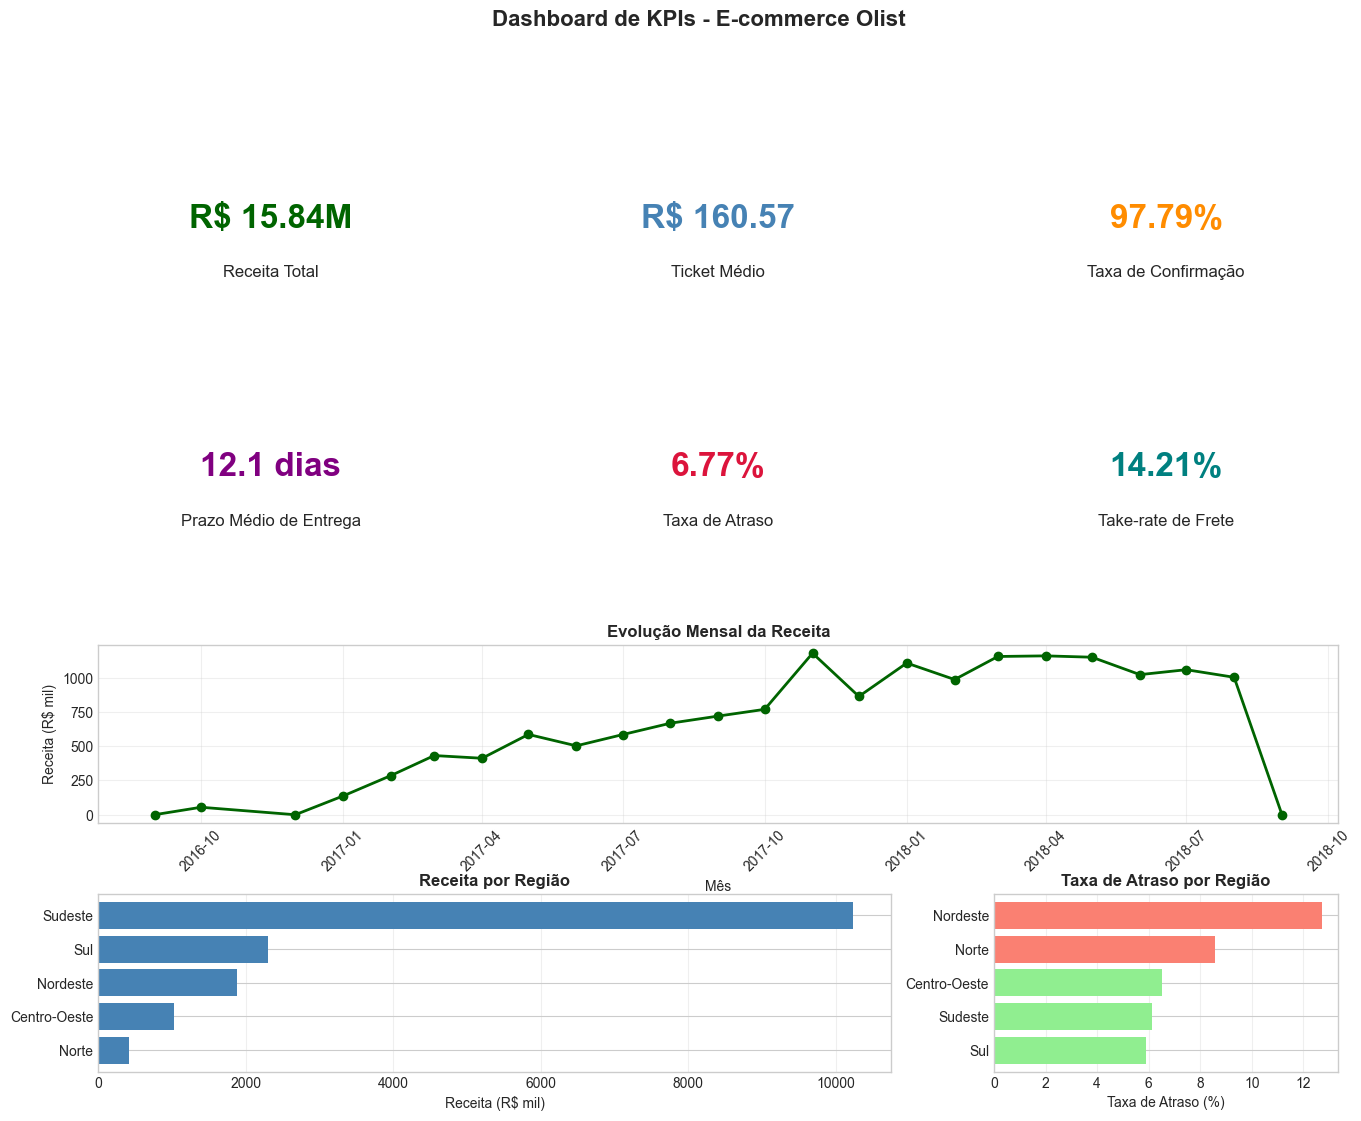

✓ Salvo: kpis_dashboard.png


In [24]:

print("6. GERANDO DASHBOARD DE KPIs")
print("-"*80)

# Criar visualização consolidada de KPIs
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# KPI 1: Receita Total
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.6, f'R$ {total_revenue/1e6:.2f}M', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='darkgreen')
ax1.text(0.5, 0.3, 'Receita Total', ha='center', va='center', fontsize=12)
ax1.axis('off')
ax1.set_facecolor('#e8f5e9')

# KPI 2: Ticket Médio
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.6, f'R$ {avg_ticket:.2f}', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='steelblue')
ax2.text(0.5, 0.3, 'Ticket Médio', ha='center', va='center', fontsize=12)
ax2.axis('off')
ax2.set_facecolor('#e3f2fd')

# KPI 3: Taxa de Confirmação
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.6, f'{confirmed_rate:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='darkorange')
ax3.text(0.5, 0.3, 'Taxa de Confirmação', ha='center', va='center', fontsize=12)
ax3.axis('off')
ax3.set_facecolor('#fff3e0')

# KPI 4: Prazo Médio
ax4 = fig.add_subplot(gs[1, 0])
ax4.text(0.5, 0.6, f'{avg_delivery_time:.1f} dias', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='purple')
ax4.text(0.5, 0.3, 'Prazo Médio de Entrega', ha='center', va='center', fontsize=12)
ax4.axis('off')
ax4.set_facecolor('#f3e5f5')

# KPI 5: Taxa de Atraso
ax5 = fig.add_subplot(gs[1, 1])
ax5.text(0.5, 0.6, f'{late_rate:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='crimson')
ax5.text(0.5, 0.3, 'Taxa de Atraso', ha='center', va='center', fontsize=12)
ax5.axis('off')
ax5.set_facecolor('#ffebee')

# KPI 6: Take-rate Frete
ax6 = fig.add_subplot(gs[1, 2])
ax6.text(0.5, 0.6, f'{freight_share:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='teal')
ax6.text(0.5, 0.3, 'Take-rate de Frete', ha='center', va='center', fontsize=12)
ax6.axis('off')
ax6.set_facecolor('#e0f2f1')

# Gráfico 7: Evolução Mensal de Receita
ax7 = fig.add_subplot(gs[2, :])
ax7.plot(monthly_kpis['month'], monthly_kpis['revenue']/1e3, 
         marker='o', linewidth=2, markersize=6, color='darkgreen')
ax7.set_xlabel('Mês')
ax7.set_ylabel('Receita (R$ mil)')
ax7.set_title('Evolução Mensal da Receita', fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# Gráfico 8: Receita por Região
ax8 = fig.add_subplot(gs[3, :2])
ax8.barh(region_kpis['region'], region_kpis['revenue']/1e3, color='steelblue')
ax8.set_xlabel('Receita (R$ mil)')
ax8.set_title('Receita por Região', fontweight='bold')
ax8.invert_yaxis()
ax8.grid(True, alpha=0.3, axis='x')

# Gráfico 9: Taxa de Atraso por Região
ax9 = fig.add_subplot(gs[3, 2])
colors = ['salmon' if x > 7 else 'lightgreen' for x in logistics_by_region['late_rate']]
ax9.barh(logistics_by_region['region'], logistics_by_region['late_rate'], color=colors)
ax9.set_xlabel('Taxa de Atraso (%)')
ax9.set_title('Taxa de Atraso por Região', fontweight='bold')
ax9.invert_yaxis()
ax9.grid(True, alpha=0.3, axis='x')

plt.suptitle('Dashboard de KPIs - E-commerce Olist', fontsize=16, fontweight='bold', y=0.995)
plt.show()
plt.savefig('./outputs/04_kpis_insights/kpis_dashboard.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Salvo: kpis_dashboard.png")


SALVAR RESUMO DE KPIs

In [22]:
print("\n7. SALVANDO RESUMO DE KPIs")
print("-"*80)

kpi_summary = pd.DataFrame({
    'KPI': [
        'Receita Total',
        'Ticket Médio',
        'Frete Médio',
        'Take-rate de Frete',
        'Prazo Médio de Entrega',
        'Taxa de Atraso',
        'Taxa de Confirmação',
        'Taxa de Cancelamento'
    ],
    'Valor': [
        f'R$ {total_revenue:,.2f}',
        f'R$ {avg_ticket:.2f}',
        f'R$ {avg_freight:.2f}',
        f'{freight_share:.2f}%',
        f'{avg_delivery_time:.2f} dias',
        f'{late_rate:.2f}%',
        f'{confirmed_rate:.2f}%',
        f'{canceled_rate:.2f}%'
    ]
})

kpi_summary.to_csv('./outputs/04_kpis_insights/kpi_summary.csv', index=False)
print("✓ Arquivo salvo: kpi_summary.csv")


insights_df = pd.DataFrame(insights)
insights_df.to_csv('./outputs/04_kpis_insights/insights_acionaveis.csv', index=False)
print("✓ Arquivo salvo: insights_acionaveis.csv")



7. SALVANDO RESUMO DE KPIs
--------------------------------------------------------------------------------
✓ Arquivo salvo: kpi_summary.csv
✓ Arquivo salvo: insights_acionaveis.csv
